# Exploring eBay Car Sales Data

Knowledge is the best resource for getting the best deal on a used car. Unlike new vehicles, used cars have been on the road and suffered some degrees of wear and tear.

We will explore a dataset of used cars from _[eBay Kleinanzeigen](https://www.ebay-kleinanzeigen.de)_, a classifieds section of the German eBay website. We want to present some insights into the nature and popularity of listed cars, then understand which cars promise the most value for potential buyers.  

The dataset was originally scraped and uploaded to Kaggle by user orgesleka.

## Summary of Findings

It is effortless to believe that as mileage increases, so does a car's wear and tear. From ebay Kleinanzeigen's listings, we observed that these two may not always correlate. Even a vehicle with low mileage can sustain more than its fair share of wear and tear, negatively impacting the value. Hence, it is essential to devise a metric that combines price, unrepaired damage, and mileage to determine a prospective purchase's overall value.

___
First, let's import our libraries & explore our data:
___

In [575]:
import pandas as pd , numpy as np , matplotlib.pyplot as plt , seaborn as sns, re
%matplotlib inline

o_df = pd.read_csv(r'autos.csv' , encoding="ISO-8859-1")
print(o_df.shape)
print(o_df.info())
o_df.head()

(371528, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


___
Data Cleaning:
-
___

In [576]:
# Making sure there aren't any duplicate rows, or all-NaN rows
print(o_df.shape)
o_df = o_df.drop_duplicates().dropna(how='all', axis=1)
print(o_df.shape)

(371528, 20)
(371524, 20)


___
We can see that we need to translate our data so we can work with it: (Internet Access Required)
___

In [577]:
# from googletrans import Translator
# tr = Translator()
# l = []
# translations = {}

# # Fetching all words we need to translate
# for col in o_df.iloc[:,[2,3,6,8,13,15]]:
#     l.append(o_df[col].unique().tolist())

# # Defining a function to translate German to English
# def tr_german(src_word):
#     dest_word = tr.translate(src_word, src='German')
#     return dest_word.text

# # Applying the function and putting the translations in a dictionary
# for sublist in l:
#     for gr_word in sublist:
#         eng_word = tr_german(gr_word)
#         translations[gr_word] = eng_word


In [578]:
# Doing a bit of manual cleaning on the resulting translations
clean_translations = {'privat': 'private','gewerblich': 'commercial','Angebot': 'offer','Gesuch': 'request','kleinwagen': 'hatchback','limousine': 'Sedan','cabrio': 'convertible','bus': 'bus',
 'kombi': 'station wagon','andere': 'other','manuell': 'manual','automatik': 'automatic','benzin': 'petrol','diesel': 'diesel','hybrid': 'hybrid','elektro': 'electric','ja': 'yes','nein': 'no'}

print(clean_translations)

{'privat': 'private', 'gewerblich': 'commercial', 'Angebot': 'offer', 'Gesuch': 'request', 'kleinwagen': 'hatchback', 'limousine': 'Sedan', 'cabrio': 'convertible', 'bus': 'bus', 'kombi': 'station wagon', 'andere': 'other', 'manuell': 'manual', 'automatik': 'automatic', 'benzin': 'petrol', 'diesel': 'diesel', 'hybrid': 'hybrid', 'elektro': 'electric', 'ja': 'yes', 'nein': 'no'}


In [579]:
# Applying the translations to our data
o_df.iloc[:,[2,3,6,8,13,15]] = o_df.iloc[:,[2,3,6,8,13,15]].apply(lambda x : x.replace(clean_translations))

o_df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,private,offer,480,test,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,private,offer,18300,test,coupe,2011,manual,190,NaN,125000,5,diesel,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",private,offer,9800,test,suv,2004,automatic,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,private,offer,1500,test,hatchback,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,private,offer,3600,test,hatchback,2008,manual,69,fabia,90000,7,diesel,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


___
For a better work flow, let's drop useless columns, re-arrange the rest, and convert them to python's snake_case:
___

In [580]:
# re-arranging columns to bring related ones closer together
o_df = o_df[['dateCreated', 'offerType', 'brand', 'model', 'name', 'vehicleType', 'kilometer', 'notRepairedDamage', 'yearOfRegistration', 'monthOfRegistration', 'fuelType', 'gearbox', 'powerPS', 'price', 'seller', 'postalCode',
         'dateCrawled', 'nrOfPictures', 'lastSeen', 'abtest']]

# converting camelCase to sanke_case using regular expressions
snake_case = {}
edits = {'kilometer':'odometer_km' , 'year_of_registration':'registration_year' , 'month_of_registration':'registration_month' , 'abtest':'a/b_test'}
for col in o_df.columns:
    snake_case[col] = re.sub(r'(?!^)([A-Z]+)', r'_\1', col).lower()
o_df.rename(columns=snake_case, inplace=True)
o_df.rename(columns=edits, inplace=True)

In [581]:
cols_to_drop = ['offer_type' , 'seller' , 'nr_of_pictures' , 'a/b_test']
for col in cols_to_drop:
    print(o_df[col].value_counts())

offer      371512
request        12
Name: offer_type, dtype: int64
private       371521
commercial         3
Name: seller, dtype: int64
0    371524
Name: nr_of_pictures, dtype: int64
test       192583
control    178941
Name: a/b_test, dtype: int64


In [582]:
# we can see that we can drop the columns in the code above, since they don't hold any significant value
# let's create a copy of the o_df before dropping these columns, just in case we need the original later

df = o_df.copy()
df.drop(columns=cols_to_drop , inplace=True)

In [583]:
df.price.value_counts().sort_index()
# After taking a closer look at the price column, we can notice some values that are outliers because they just don't make sense, so we need to filter them out
df = df[df.price.between(400,395000)]

In [584]:
df.head()

,date_created,brand,model,name,vehicle_type,odometer_km,not_repaired_damage,registration_year,registration_month,fuel_type,gearbox,power_ps,price,postal_code,date_crawled,last_seen
0,2016-03-24 00:00:00,volkswagen,golf,Golf_3_1.6,NaN,150000,NaN,1993,0,petrol,manual,0,480,70435,2016-03-24 11:52:17,2016-04-07 03:16:57
1,2016-03-24 00:00:00,audi,NaN,A5_Sportback_2.7_Tdi,coupe,125000,yes,2011,5,diesel,manual,190,18300,66954,2016-03-24 10:58:45,2016-04-07 01:46:50
2,2016-03-14 00:00:00,jeep,grand,"Jeep_Grand_Cherokee_""Overland""",suv,125000,NaN,2004,8,diesel,automatic,163,9800,90480,2016-03-14 12:52:21,2016-04-05 12:47:46
3,2016-03-17 00:00:00,volkswagen,golf,GOLF_4_1_4__3TÜRER,hatchback,150000,no,2001,6,petrol,manual,75,1500,91074,2016-03-17 16:54:04,2016-03-17 17:40:17
4,2016-03-31 00:00:00,skoda,fabia,Skoda_Fabia_1.4_TDI_PD_Classic,hatchback,90000,no,2008,7,diesel,manual,69,3600,60437,2016-03-31 17:25:20,2016-04-06 10:17:21


___
Data Visualization & Analysis:
---
___

We'll now calculate the distibution percentage of ads by date, for each column in the dates category:
___

In [585]:
# First, we need to convert the date columns into date format:
date_cols = ['date_created', 'date_crawled', 'last_seen']
for col in date_cols:
    df[col] = pd.to_datetime(df[col]).dt.date

# now it's ready for analysis
for col in date_cols:
    display(df[col].value_counts(normalize=True, dropna=False).sort_index().to_frame().transpose())

,2014-03-10,2015-03-20,2015-06-11,2015-06-18,2015-08-07,2015-08-10,2015-09-04,2015-09-09,2015-10-14,2015-11-02,...,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07
date_created,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000006,0.000003,0.000003,0.000003,...,0.034043,0.033308,0.031923,0.034117,0.035165,0.039307,0.03789,0.011562,0.003108,0.001529


,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,...,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07
date_crawled,0.025745,0.014494,0.035666,0.033437,0.034079,0.032629,0.032737,0.036463,0.015897,0.036229,...,0.033979,0.033452,0.031841,0.034287,0.035288,0.039096,0.037793,0.012751,0.003114,0.001596


,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,...,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07
last_seen,0.001233,0.004045,0.005041,0.007792,0.009658,0.01126,0.012786,0.0231,0.008325,0.012027,...,0.022921,0.02334,0.023941,0.023832,0.024775,0.025212,0.025276,0.12837,0.221889,0.132003


___
It also seems that the "registiration_year" column is in need of a closer look;
___
looks like it contains some odd values:
- The minimum value is 1000, before cars were invented
- The maximum value is 9999, many years into the future

Because a car can't be first registered after the listing was seen, any vehicle with a registration year above 2016 is definitely inaccurate. Determining the earliest valid year is more difficult. Realistically, it could be somewhere in the first few decades of the 1900s.

So after doing a little research, the majority of brands and models before the year 1920, didn't really exist back then, so it's safe to assume that those are all incorrect entries, and we'll be using the year 1920 as the earliest valid year.

In [586]:
df = df[df.registration_year.between(1920,2016)]
df.head()

,date_created,brand,model,name,vehicle_type,odometer_km,not_repaired_damage,registration_year,registration_month,fuel_type,gearbox,power_ps,price,postal_code,date_crawled,last_seen
0,2016-03-24,volkswagen,golf,Golf_3_1.6,NaN,150000,NaN,1993,0,petrol,manual,0,480,70435,2016-03-24,2016-04-07
1,2016-03-24,audi,NaN,A5_Sportback_2.7_Tdi,coupe,125000,yes,2011,5,diesel,manual,190,18300,66954,2016-03-24,2016-04-07
2,2016-03-14,jeep,grand,"Jeep_Grand_Cherokee_""Overland""",suv,125000,NaN,2004,8,diesel,automatic,163,9800,90480,2016-03-14,2016-04-05
3,2016-03-17,volkswagen,golf,GOLF_4_1_4__3TÜRER,hatchback,150000,no,2001,6,petrol,manual,75,1500,91074,2016-03-17,2016-03-17
4,2016-03-31,skoda,fabia,Skoda_Fabia_1.4_TDI_PD_Classic,hatchback,90000,no,2008,7,diesel,manual,69,3600,60437,2016-03-31,2016-04-06


___
Now, let's look at the average price by brand:
___

In [587]:
av_price_by_brand = round(df.groupby('brand')[['price','odometer_km']].mean())
# Sorting by price (highest to lowest)
av_price_by_brand.sort_values('odometer_km' , ascending=False , inplace=True)
av_price_by_brand.transpose()

brand,saab,volvo,rover,chrysler,bmw,mercedes_benz,audi,alfa_romeo,volkswagen,opel,...,suzuki,hyundai,chevrolet,porsche,smart,mini,sonstige_autos,dacia,lada,trabant
price,4140.0,5488.0,1809.0,4302.0,8636.0,8655.0,9265.0,4545.0,5690.0,3281.0,...,4308.0,5718.0,7186.0,43212.0,3666.0,10142.0,15690.0,5943.0,3280.0,2248.0
odometer_km,141364.0,138008.0,135339.0,134234.0,133038.0,130802.0,129465.0,128774.0,128062.0,127788.0,...,105499.0,103477.0,100290.0,100050.0,99640.0,93577.0,88920.0,85986.0,73433.0,55456.0


___
Here comes a question; Are the prices affected by the milage on the cars?, and does the brand play any part in that effect?
___
To find that out, we need to put our data in a nice bar chart in order to better visualize it and understand it:

<AxesSubplot: xlabel='brand'>

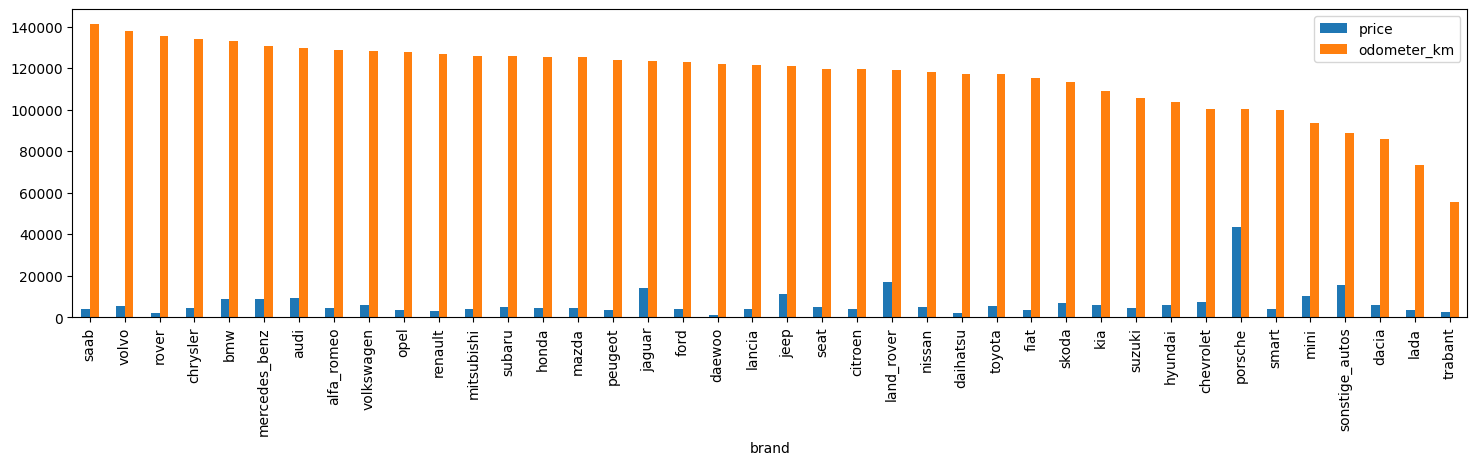

In [588]:
av_price_by_brand.plot.bar(figsize=(18, 4))

Observations:
___
It looks like the price and the milage doesn't affect each other as much as they were expected to, on the other hand, there seem to be a few brands like (Porsche), that actually show a unique result, where the average price is relatively much higher than the other brands, regardless of the odometer range


___
Now, let's look at the most common brand/model combinations:
___

In [589]:
df[['brand','model']].value_counts().to_frame()[:20].rename(columns={0:'count'}).transpose()

brand volkswagen    bmw volkswagen  opel  audi volkswagen  opel mercedes_benz  \
model       golf    3er       polo corsa    a4     passat astra      c_klasse   
count      26057  18968      10525  9781  9625       9475  9253          8377   

brand   bmw mercedes_benz  audi        ford  volkswagen   ford peugeot  smart  \
model   5er      e_klasse    a3    a6 focus transporter fiesta 2_reihe fortwo   
count  8131          7197  6111  5699  5392        5172   4636    4524   4125   

brand mercedes_benz renault   bmw  
model      a_klasse  twingo   1er  
count          3901    3778  3697

## Next:
- divide milage to value ranges
- find out how much cheaper cars with damage are, than their non-damaged counterparts in the same km range

In [590]:
df.not_repaired_damage.value_counts(dropna=False)

no     248371
NaN     52157
yes     27364
Name: not_repaired_damage, dtype: int64

In [591]:
df.odometer_km.value_counts()

150000    208482
125000     34793
100000     14515
90000      11730
80000      10415
70000       9291
60000       8350
50000       7275
40000       6155
30000       5681
20000       5177
5000        4324
10000       1704
Name: odometer_km, dtype: int64

In [592]:
df.insert(6, column='odometer_range', value=0)
def km_range(km):
    if 120000 < km <= 150000:
        km = '120k-150k'
    elif 90000 < km <= 120000:
        km = '90k-120k'
    elif 60000 < km <= 90000:
        km = '60k-90k'
    elif 30000 < km <= 60000:
        km = '30k-60k'
    elif 1000 <= km <= 30000:
        km = '1k-30k'
    else:
        km = 0
    return km
df.odometer_range = df.odometer_km.map(km_range)

In [593]:
df.head()

,date_created,brand,model,name,vehicle_type,odometer_km,odometer_range,not_repaired_damage,registration_year,registration_month,fuel_type,gearbox,power_ps,price,postal_code,date_crawled,last_seen
0,2016-03-24,volkswagen,golf,Golf_3_1.6,NaN,150000,120k-150k,NaN,1993,0,petrol,manual,0,480,70435,2016-03-24,2016-04-07
1,2016-03-24,audi,NaN,A5_Sportback_2.7_Tdi,coupe,125000,120k-150k,yes,2011,5,diesel,manual,190,18300,66954,2016-03-24,2016-04-07
2,2016-03-14,jeep,grand,"Jeep_Grand_Cherokee_""Overland""",suv,125000,120k-150k,NaN,2004,8,diesel,automatic,163,9800,90480,2016-03-14,2016-04-05
3,2016-03-17,volkswagen,golf,GOLF_4_1_4__3TÜRER,hatchback,150000,120k-150k,no,2001,6,petrol,manual,75,1500,91074,2016-03-17,2016-03-17
4,2016-03-31,skoda,fabia,Skoda_Fabia_1.4_TDI_PD_Classic,hatchback,90000,60k-90k,no,2008,7,diesel,manual,69,3600,60437,2016-03-31,2016-04-06


In [606]:
av_price_by_km = round(df.groupby(['odometer_range','not_repaired_damage'])['price'].mean().reset_index())
av_price_by_km_repaired = av_price_by_km[av_price_by_km.not_repaired_damage == 'no'].sort_values('price' , ascending=False).drop(columns='not_repaired_damage', axis=1).rename()
av_price_by_km_defective = av_price_by_km[av_price_by_km.not_repaired_damage == 'yes'].sort_values('price' , ascending=False).drop(columns='not_repaired_damage', axis=1)

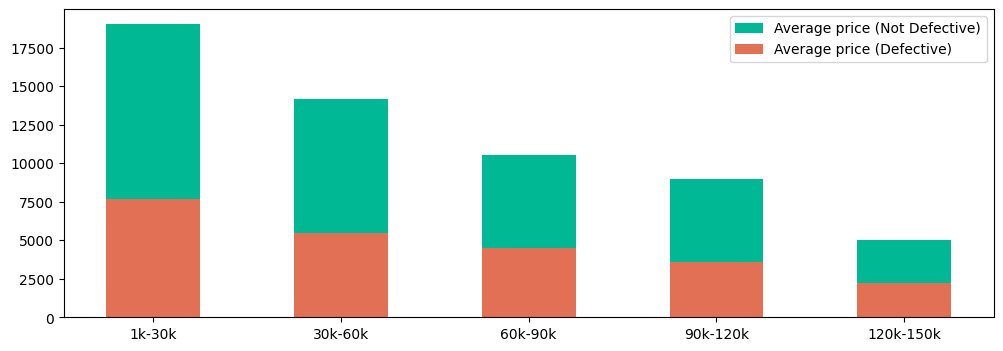

In [613]:
plt.figure(figsize=(12, 4))

barWidth = 0.5
plt.bar(av_price_by_km_repaired.odometer_range, av_price_by_km_repaired.price, width=barWidth, color='#00b894', label='Average price (Not Defective)')
plt.bar(av_price_by_km_repaired.odometer_range, av_price_by_km_defective.price, width=barWidth, color='#e17055', label='Average price (Defective)')

plt.legend()
plt.show()

So, from the previous bar chart, we can conclude that, on average, defective models are more that 50% cheaper than their counterparts
___